# CSCA 5622 Supervised Learning Final Project

Name: Nobuo Takizawa  
GitHub: https://github.com/nobuyo/introduction-to-machine-learning-supervised-learning

# Introduction

## About the topic

If the disease could be predicted from data available to the user simply by asking questions, without involving medical procedures such as blood tests, the risk of heart disease could be more easily learned on a daily basis. For example, this could be applied to a web application that would ask people to enter their lifestyle habits and predict their high or low risk.
Honestly, I don't think this would be useful in a medical situation, but it could be useful in raising awareness about health. This could have a positive impact on people's wellbeing.

## What is the type of learning/algorithms and type of task?

The data contains target label; hence, the learning type is Supervised Learning. The type of task is binary class classification since my objection is predict whether the sample has heart disease or not.


# Project Goal

The goal of this project is to build a model that can predict with good accuracy the likelihood of heart disease from basic data on health status and lifestyle.

# About The Data

The data is published on kaggle[1].

This dataset was obtained from the web and processed from the US Centers for Disease Control and Prevention (CDC) published data on the health status and habits of US adults in the year 2022. This data was brought to us by a survey called BRFSS.

The following is a quote from the CDC website regarding the BRFSS:

> The Behavioral Risk Factor Surveillance System (BRFSS) is the nation’s premier system of health-related telephone surveys that collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services. Established in 1984 with 15 states, BRFSS now collects data in all 50 states as well as the District of Columbia and three U.S. territories. BRFSS completes more than 400,000 adult interviews each year, making it the largest continuously conducted health survey system in the world. (https://www.cdc.gov/brfss/annual_data/annual_2022.html)

Here is a description of how the data was collected and processed, quote from the dataset page on Kaggle:

> Data are from the CDC. Data organization and cleaning was done using pandas in Python. First, the original dataset was converted from SAS to CSV format. Variables with a direct or indirect effect on heart disease were selected. You can find info about data preprocessing here: https://github.com/kamilpytlak/data-science-projects/blob/main/heart-disease-prediction/2022/notebooks/data_processing.ipynb

---

[1] Kamil Pytlak. (2023, October). Indicators of Heart Disease (2022 UPDATE), Version 6. Retrieved May 28th, 2024 from https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease.

# Import Libraries / Read the data

In [1]:
# import libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, f1_score

# ignore warnings
import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('/kaggle/input/personal-key-indicators-of-heart-disease/2022/heart_2022_with_nans.csv')

# Data Description

Here is the basic info about the data:

- Number of samples: 445132
- Number of columns: 40 (include target column)
- Data type of features: 6 numeric, 34 categorical

## Description of features

The dataset consists of the following features:

- Basic personal data such as residence, race, age, height, weight
- Pre-existing medical conditions and history　such as had diabetes
- Lifestyle characteristics such as sleep hours, had physical activities

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer              44

# Data Cleaning

In this section, I will do some data cleaning as following steps:

* Check missing data
* Check duplicated rows, and remove them if exists
* Drop unnesessary columns
* Check data types, and do munging if necessary
* Impute missing data
* Handle outlier samples

## Check the missing data

The plot below is a heatmap of missing values. It seems that there is considerable amount of nulls in this data.

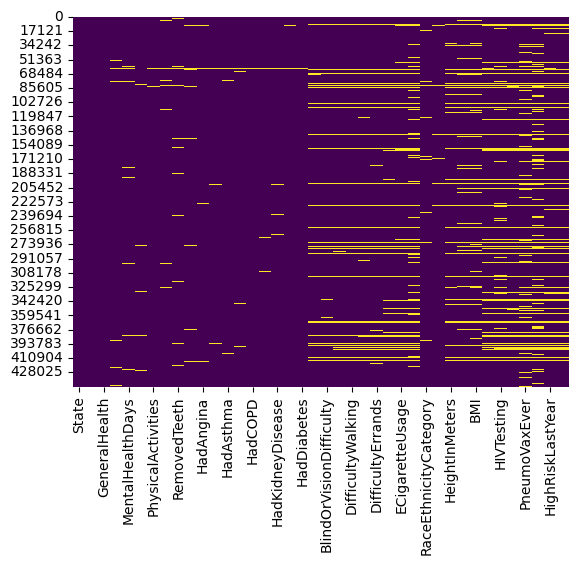

In [4]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

In [5]:
df.isnull().sum()

State                            0
Sex                              0
GeneralHealth                 1198
PhysicalHealthDays           10927
MentalHealthDays              9067
LastCheckupTime               8308
PhysicalActivities            1093
SleepHours                    5453
RemovedTeeth                 11360
HadHeartAttack                3065
HadAngina                     4405
HadStroke                     1557
HadAsthma                     1773
HadSkinCancer                 3143
HadCOPD                       2219
HadDepressiveDisorder         2812
HadKidneyDisease              1926
HadArthritis                  2633
HadDiabetes                   1087
DeafOrHardOfHearing          20647
BlindOrVisionDifficulty      21564
DifficultyConcentrating      24240
DifficultyWalking            24012
DifficultyDressingBathing    23915
DifficultyErrands            25656
SmokerStatus                 35462
ECigaretteUsage              35660
ChestScan                    56046
RaceEthnicityCategor

## Check duplicated rows

Next, I'd check duplicated samples.

In [6]:
df.duplicated().sum()

157

157 samples are duplicated. So I'll remove it.

In [7]:
df.drop_duplicates(inplace=True)

## Drop unnecessary columns

In general, the more columns in a data set, the more samples are needed to obtain generalization performance.
I want to drop some extra columns to compactize the data.

First, there are several columns that I think they are not necessary because of their meaning. The column and the reason are follows:

* `State`: It would be helpful if the characteristics of the area were recorded in more detail, for example, whether it is an industrial area or not, but we do not consider state information to be relevant for predicting disease.
* `HIVTesting`, `ChestScan`: They represents whether the sample have tested or not, not positive/negative.
* `LastCheckupTime`: It simply represents the time the test was taken, which is useful for early detection, but since what I want to predict here is not survival rates, etc., but whether or not the disease was present, therefore I will remove it.
* `ECigaretteUsage`: I think `SmokerStatus` column already shows the same information.
* `DeafOrHardOfHearing, BlindOrVisionDifficulty, DifficultyConcentrating, DifficultyDressingBathing, DifficultyErrands`: There also less related to a heart disease by their meanings.
* `DifficultyWalking`: Walkability can be considered a risk linked to inactivity, but physical activity is already present in this dataset.

In [8]:
# drop columns mentioned above
df.drop(columns=[
    'State',
    'HIVTesting',
    'ChestScan',
    'LastCheckupTime',
    'ECigaretteUsage',
    'DeafOrHardOfHearing',
    'BlindOrVisionDifficulty',
    'DifficultyConcentrating',
    'DifficultyDressingBathing',
    'DifficultyErrands',
    'DifficultyWalking',
], inplace=True)

Additionally, I would like to see some columns on vaccines.
I believe that vaccines for diseases of concern for serious illness in the elderly, such as pneumococcal disease, will be given more frequently to certain age groups.
In other words, the data may just represent the same kind of data as AgeCategory.

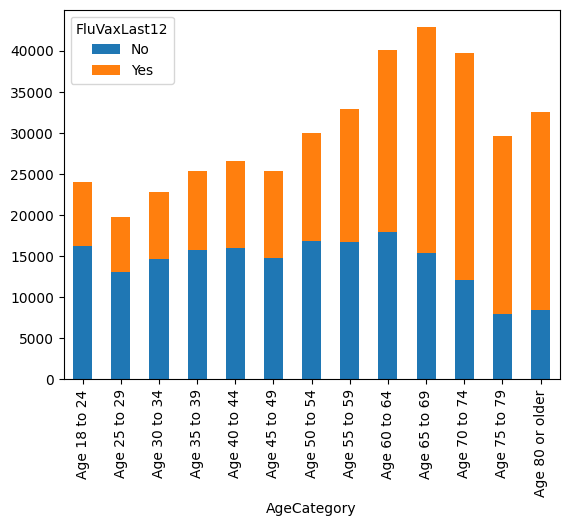

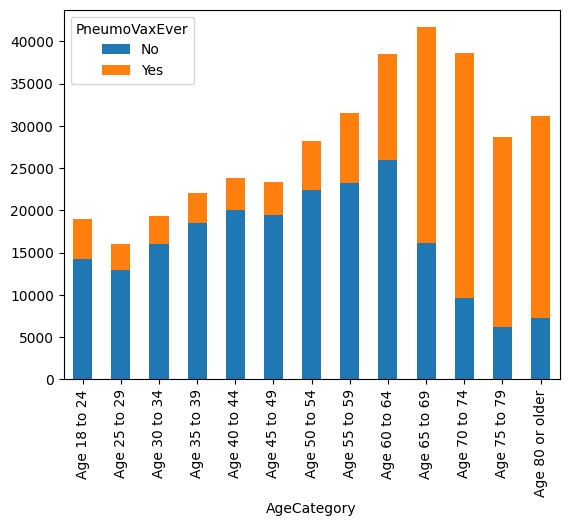

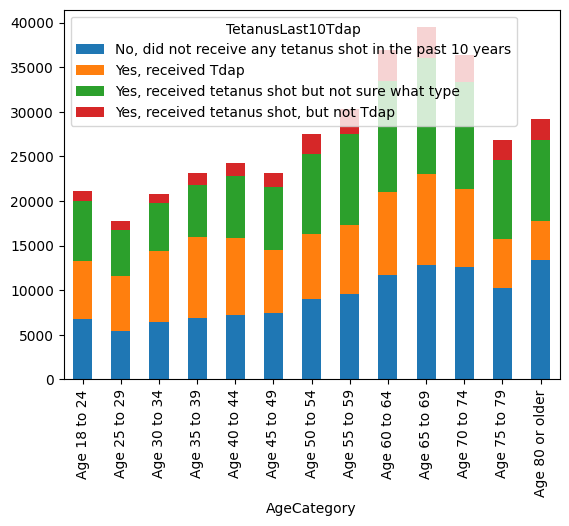

In [9]:
vaccines = ['FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap']
for v in vaccines:
    grouped = df.groupby(['AgeCategory', v]).size().unstack(fill_value=0)
    grouped.plot(kind='bar', stacked=True)

Then I found that the FluVax and PneumoVax are　showing a bias toward the elderly, as expected.
I also found that the distribution of tetanus vaccine was not skewed by age.
I will drop the columns on all vaccines as well, as I see no reason to leave the one on tetanus alone.

In [10]:
df.drop(columns=vaccines, inplace=True)

As the same reason above, let's take a look at AgeCategory and RemovedTeeth.

<Axes: xlabel='AgeCategory'>

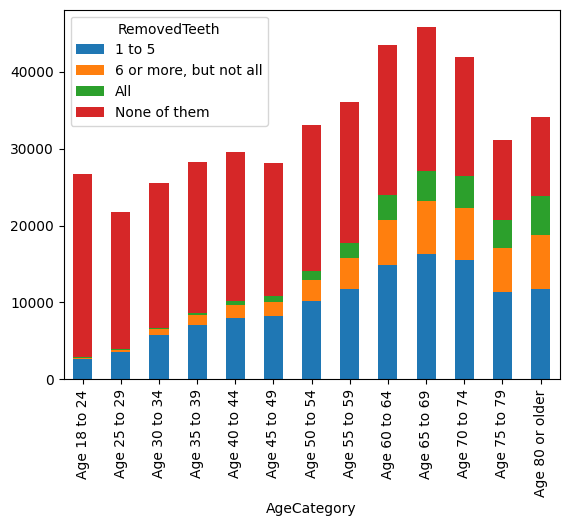

In [11]:
grouped = df.groupby(['AgeCategory', 'RemovedTeeth']).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True)

RemovedTeeth is more common in older adults, and it is likely that missing teeth in this data is merely a projection of whether or not a person is older. Therefore, this column should also be excluded.

In [12]:
df.drop(columns=['RemovedTeeth'], inplace=True)

## Handling nulls for categorical features

Here I deal with missing categorical features.
First I check how much is missing and the distribution of the data.

In [13]:
df.select_dtypes('object').isnull().mean()

Sex                      0.000000
GeneralHealth            0.002681
PhysicalActivities       0.002445
HadHeartAttack           0.006877
HadAngina                0.009888
HadStroke                0.003488
HadAsthma                0.003973
HadSkinCancer            0.007052
HadCOPD                  0.004976
HadDepressiveDisorder    0.006308
HadKidneyDisease         0.004317
HadArthritis             0.005906
HadDiabetes              0.002432
SmokerStatus             0.079366
RaceEthnicityCategory    0.031570
AgeCategory              0.020381
AlcoholDrinkers          0.104338
HighRiskLastYear         0.113438
CovidPos                 0.113755
dtype: float64

In [14]:
# HadHeartAttack is a target column so I won't impute this.
df.dropna(subset=['HadHeartAttack'], inplace=True)

The plots below show the value count of the column. From this distribution, I can see that some of the values are relatively unbiased and can be completed randomly, while others should be completed by the mode mode due to the prominence of a single value.

I'm going to impute the columns as follows:

* Random impute
    * AlcoholDrinkers
    * AgeCategory
* Mode impute
    * PhysicalActivities
    * HadAngina
    * HadStroke
    * HadAsthma
    * HadSkinCancer
    * HadCOPD
    * HadDepressiveDisorder
    * HadKidneyDisease
    * HadArthritis
    * HadDiabetes
    * SmokerStatus
    * RaceEthnicityCategory
    * AlcoholDrinkers
    * HighRiskLastYear
    * CovidPos

As an exception, samples with missing `GeneralHealth` will be dropped.
This value may be associated with other pre-existing conditions and neither random nor mode is considered suitable.
A potentially valid option is complementation by kNN, but it is costly and the missing rate is very low, so I drop it.

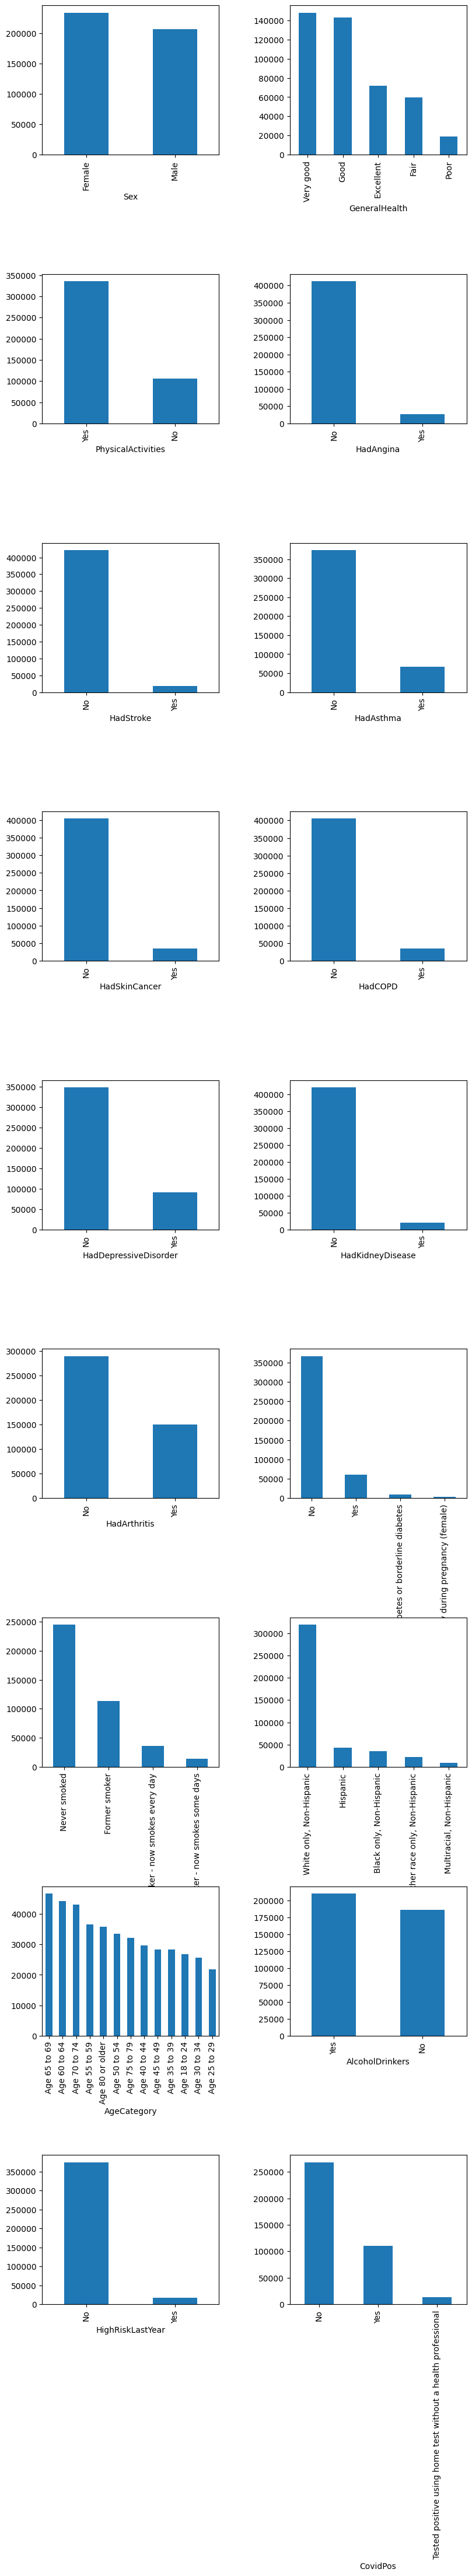

In [15]:
# 9x2 subplots
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(8, 40))
flat_ax = ax.ravel()
fig.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.8)

for ix, c in enumerate(df.select_dtypes('object').drop(columns=['HadHeartAttack']).columns):
    df[c].value_counts().plot(kind='bar', ax=flat_ax[ix])

In [16]:
df.dropna(subset=['GeneralHealth'], inplace=True)

random_impute_cols = [
    'AlcoholDrinkers',
    'AgeCategory'
]
for c in random_impute_cols:
    pool = df[c].dropna()
    df[c] = df[c].apply(lambda x: np.random.choice(pool) if pd.isnull(x) else x)

    
mode_impute_cols = [
    'PhysicalActivities',
    'HadAngina',
    'HadStroke',
    'HadAsthma',
    'HadSkinCancer',
    'HadCOPD',
    'HadDepressiveDisorder',
    'HadKidneyDisease',
    'HadArthritis',
    'HadDiabetes',
    'SmokerStatus',
    'RaceEthnicityCategory',
    'AgeCategory',
    'AlcoholDrinkers',
    'HighRiskLastYear',
    'CovidPos',
]
for c in mode_impute_cols:
    df[c].fillna(df[c].mode()[0], inplace=True)

In [17]:
df.select_dtypes('object').isnull().sum()

Sex                      0
GeneralHealth            0
PhysicalActivities       0
HadHeartAttack           0
HadAngina                0
HadStroke                0
HadAsthma                0
HadSkinCancer            0
HadCOPD                  0
HadDepressiveDisorder    0
HadKidneyDisease         0
HadArthritis             0
HadDiabetes              0
SmokerStatus             0
RaceEthnicityCategory    0
AgeCategory              0
AlcoholDrinkers          0
HighRiskLastYear         0
CovidPos                 0
dtype: int64

## Handling nulls of numeric features



* Check data distribution
* Handle outliers
* Impute missing values

### Check the data distribution

Here is the plot and skewness for the numeric features.
HeightInMeters, WeightInKilograms, and BMI generally follow a mostly normal distribution, which seems to be the case here as well.
The other columns appear to be non-normally distributed.

On skewness, some columns have large positive skewness. This indicates that the distribution extends to the right. 

PhysicalHealthDays skewness: 2.1944409317564215
MentalHealthDays skewness: 2.128806390103071
SleepHours skewness: 0.7473336124559858
HeightInMeters skewness: 0.030705160898877627
WeightInKilograms skewness: 1.0755730815977609
BMI skewness: 1.387078637154842


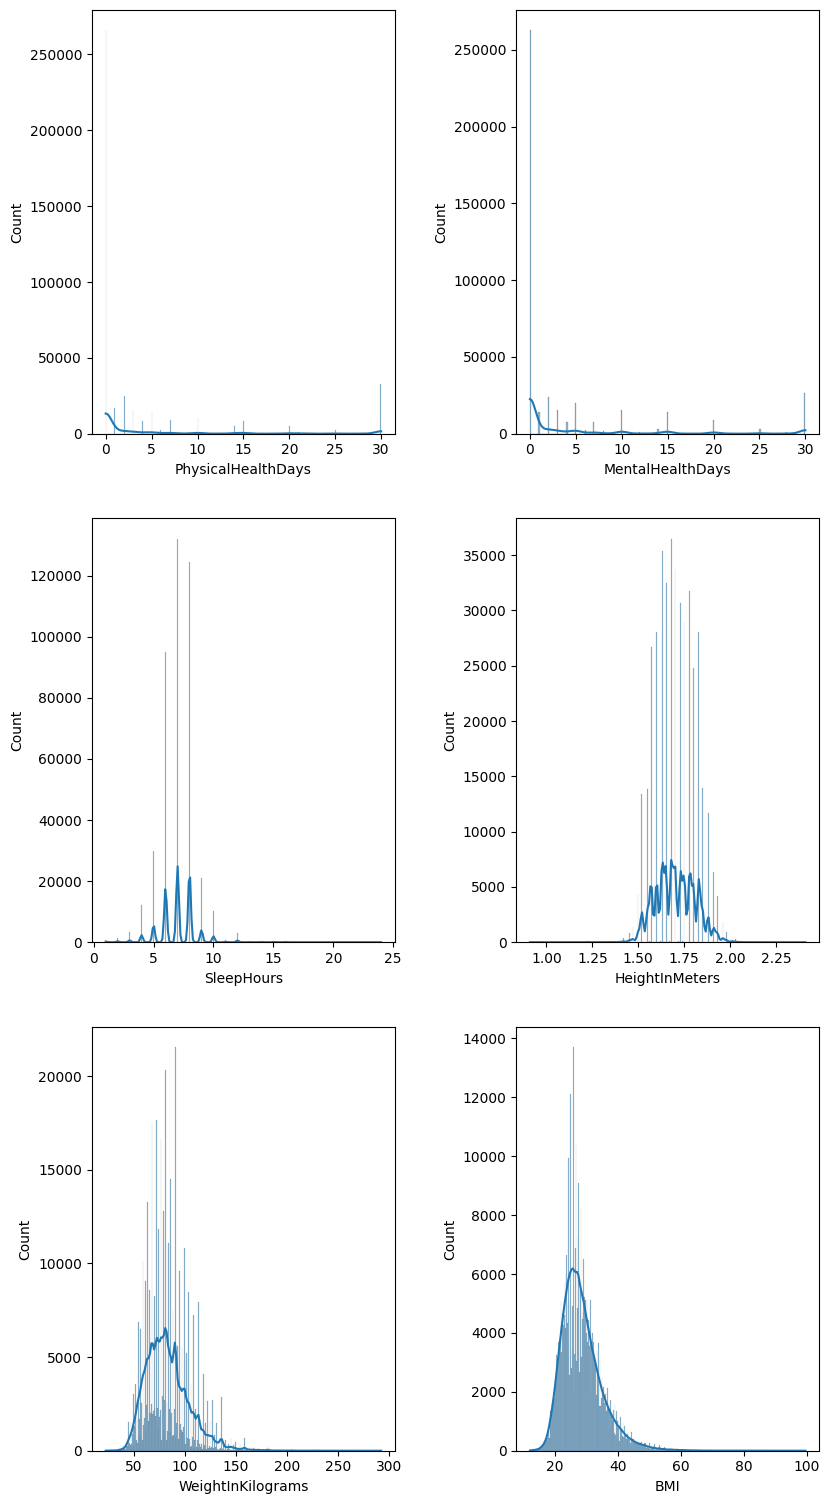

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 15))
flat_ax = ax.ravel()
fig.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.2)

# print skewness and show plot
for ix, c in enumerate(df.select_dtypes('float64').columns):
    print('{} skewness: {}'.format(c, df[c].skew()))
    sns.histplot(df[c], kde=True, ax=flat_ax[ix])

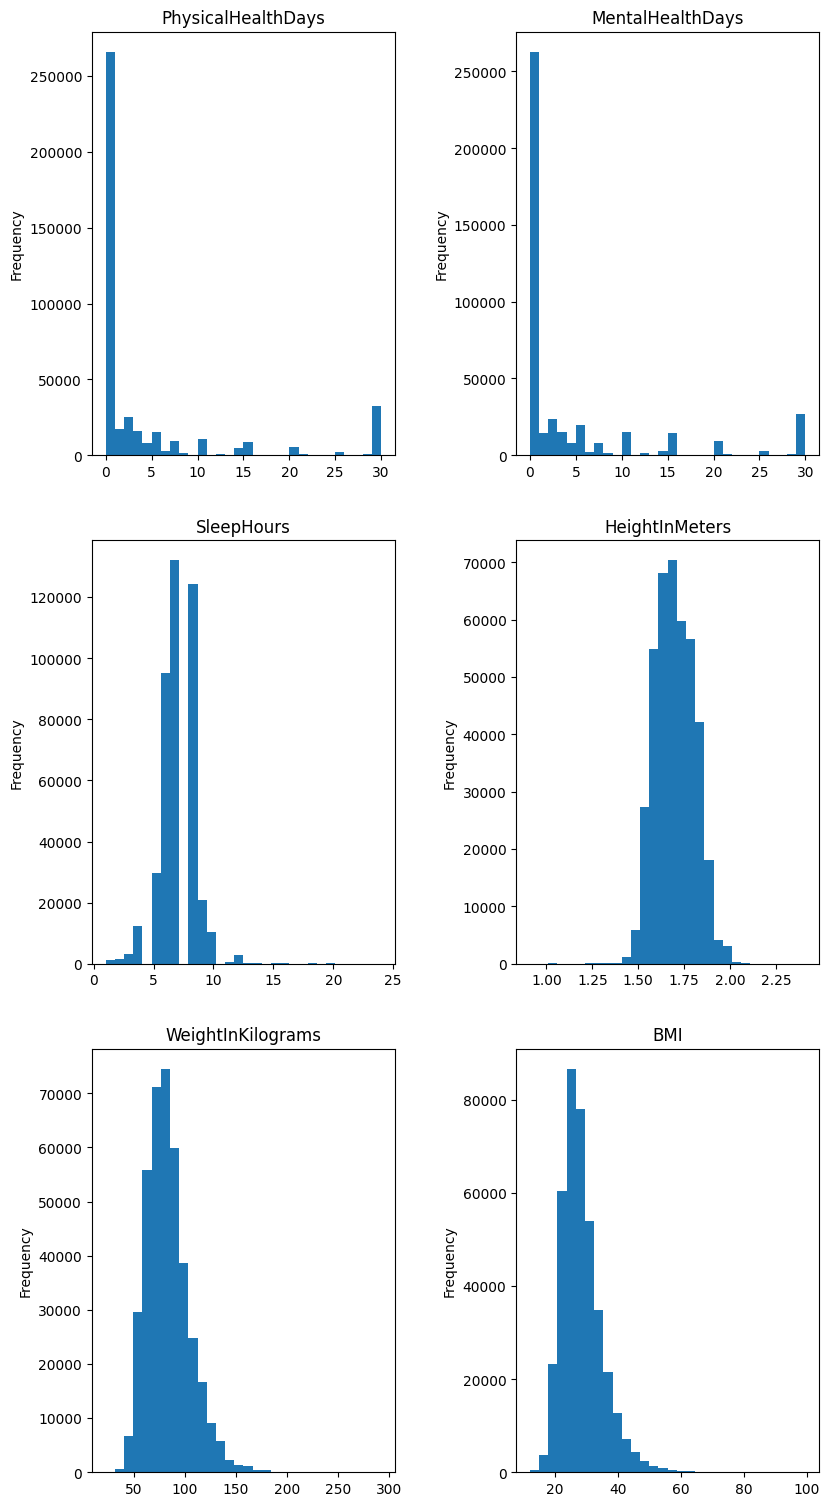

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 15))
flat_ax = ax.ravel()
fig.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.2)

# print skewness and show plot
for ix, c in enumerate(df.select_dtypes('float64').columns):
    flat_ax[ix].set_title(c)
    df[c].plot(kind='hist', bins=30, ax=flat_ax[ix])

#### Impute missing values

Since these are numeric features, the average value may be used. However, as discussed below, some values contain outliers.  
So for height and weight, we simply fill in the missing values randomly from other samples, and use the mode for those that are mostly representative values, such as sleep duration.

In [20]:
# show missing rate
df.select_dtypes('float64').isnull().mean()

PhysicalHealthDays    0.023515
MentalHealthDays      0.019564
SleepHours            0.011479
HeightInMeters        0.063175
WeightInKilograms     0.093278
BMI                   0.108260
dtype: float64

In [21]:
for c in ['HeightInMeters', 'WeightInKilograms']:
    pool = df[c].dropna()
    df[c] = df[c].apply(lambda x: np.random.choice(pool) if pd.isnull(x) else x)

for c in ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours']:
    df[c].fillna(df[c].mode()[0], inplace=True)

df['BMI'] = df.apply(lambda x: x['WeightInKilograms'] / (x['HeightInMeters'] ** 2) if pd.isnull(x['BMI']) else x['BMI'], axis=1)

In [22]:
# show missing rate
df.select_dtypes('float64').isnull().mean()

PhysicalHealthDays    0.0
MentalHealthDays      0.0
SleepHours            0.0
HeightInMeters        0.0
WeightInKilograms     0.0
BMI                   0.0
dtype: float64

#### Handle outliers

Looking at the distribution plots earlier, we can see that some of the samples contain fairly large values for BMI and some have very long sleep durations.

Due to the differences in distribution described above, z-score and IQR are used to handle outliers. Which method is used for which column is as follows:

* z-score
  * HeightInMeters
  * WeightInKilograms
  * BMI
* IQR
  * SleepHours
  * PhysicalHealthDays
  * MentalHealthDays

PhysicalHealthDays       Axes(0.125,0.653529;0.352273x0.226471)
MentalHealthDays      Axes(0.547727,0.653529;0.352273x0.226471)
SleepHours               Axes(0.125,0.381765;0.352273x0.226471)
HeightInMeters        Axes(0.547727,0.381765;0.352273x0.226471)
WeightInKilograms            Axes(0.125,0.11;0.352273x0.226471)
BMI                       Axes(0.547727,0.11;0.352273x0.226471)
dtype: object

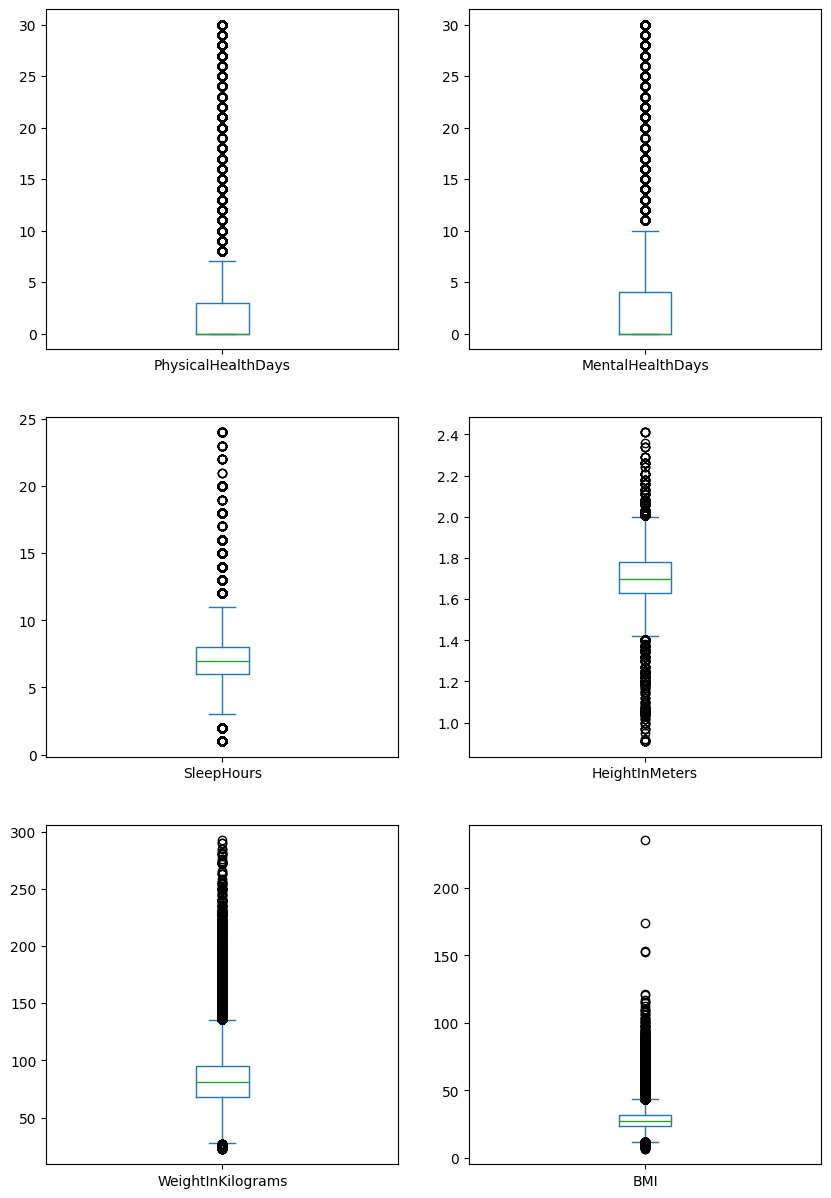

In [23]:
# box plot (before)
df.select_dtypes('float64').plot(kind='box', subplots=True, figsize=(10,15), layout=(3,2))

In [24]:
def remove_outliers_zscore(df, columns, threshold=3):
    z_scores = np.abs(stats.zscore(df[columns].dropna()))
    df_no_outliers = df[(z_scores < threshold).all(axis=1)]
    return df_no_outliers

df = remove_outliers_zscore(df, ['HeightInMeters', 'WeightInKilograms', 'BMI'])

def remove_outliers_iqr(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df

df = remove_outliers_iqr(df, columns=['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours'])

PhysicalHealthDays       Axes(0.125,0.653529;0.352273x0.226471)
MentalHealthDays      Axes(0.547727,0.653529;0.352273x0.226471)
SleepHours               Axes(0.125,0.381765;0.352273x0.226471)
HeightInMeters        Axes(0.547727,0.381765;0.352273x0.226471)
WeightInKilograms            Axes(0.125,0.11;0.352273x0.226471)
BMI                       Axes(0.547727,0.11;0.352273x0.226471)
dtype: object

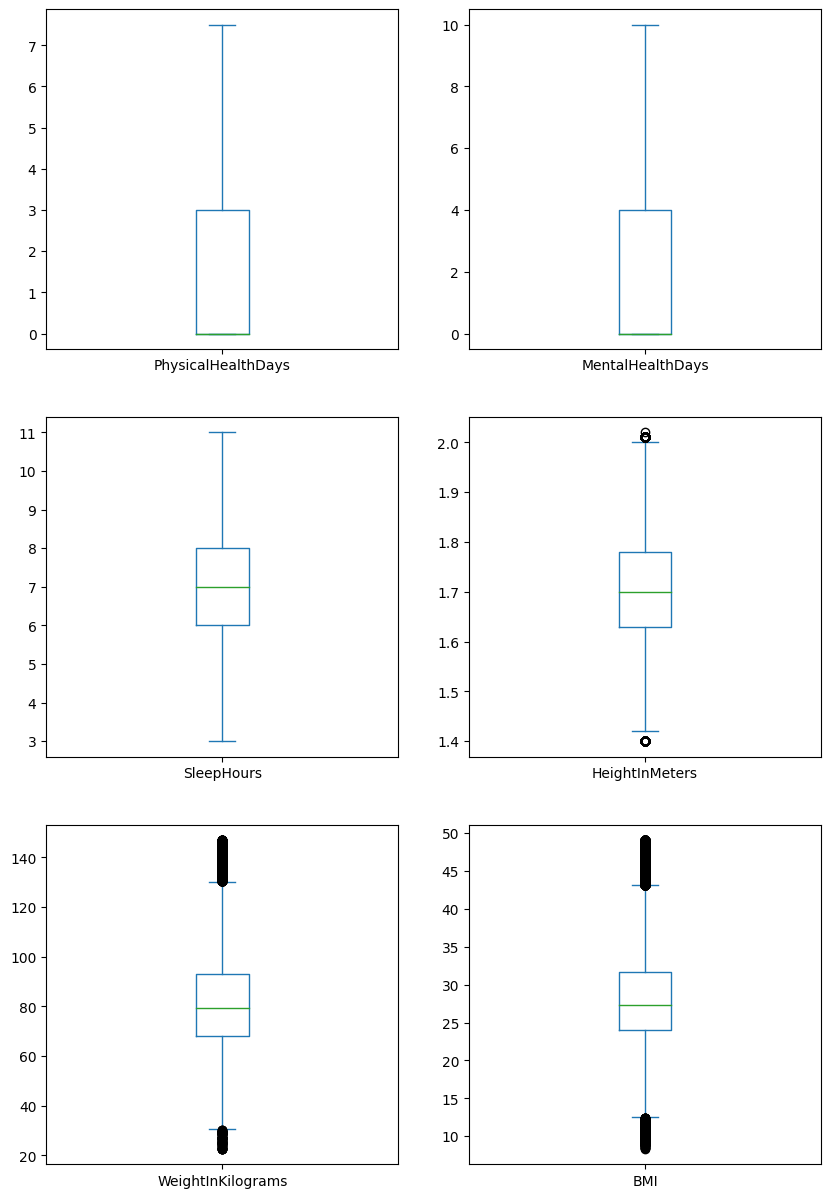

In [25]:
df.select_dtypes('float64').plot(kind='box', subplots=True, figsize=(10,15), layout=(3,2))

Looks good!

#### Data cleaning summary

There are 24 columns remaining, and 430k+ samples.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 432723 entries, 0 to 445131
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Sex                    432723 non-null  object 
 1   GeneralHealth          432723 non-null  object 
 2   PhysicalHealthDays     432723 non-null  float64
 3   MentalHealthDays       432723 non-null  float64
 4   PhysicalActivities     432723 non-null  object 
 5   SleepHours             432723 non-null  float64
 6   HadHeartAttack         432723 non-null  object 
 7   HadAngina              432723 non-null  object 
 8   HadStroke              432723 non-null  object 
 9   HadAsthma              432723 non-null  object 
 10  HadSkinCancer          432723 non-null  object 
 11  HadCOPD                432723 non-null  object 
 12  HadDepressiveDisorder  432723 non-null  object 
 13  HadKidneyDisease       432723 non-null  object 
 14  HadArthritis           432723 non-null  o

# EDA

Let's look at the cleaned data again.

* The main features with a simple plot.
* crosstabulations of target variable and other variables, and heatmaps.

First we take a look at the target column, `HadHeartAttack`. The distribution seems highly imbalance, therefore I might need to handle it with a technique such as SMOTE.

<Axes: xlabel='HadHeartAttack'>

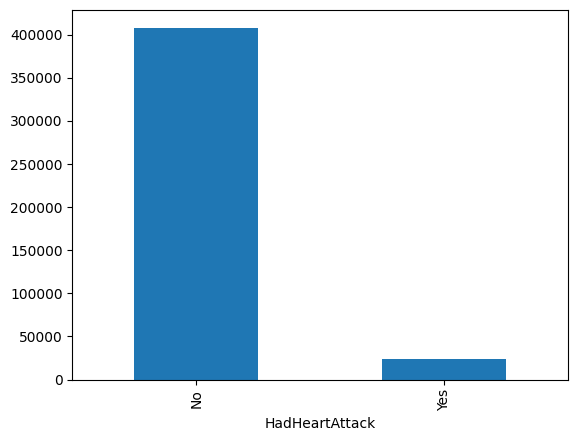

In [27]:
df['HadHeartAttack'].value_counts().plot(kind='bar')

Here we simply look at other features.

The following can be seen:

* There is a bias in the presence or absence of pre-existing conditions.

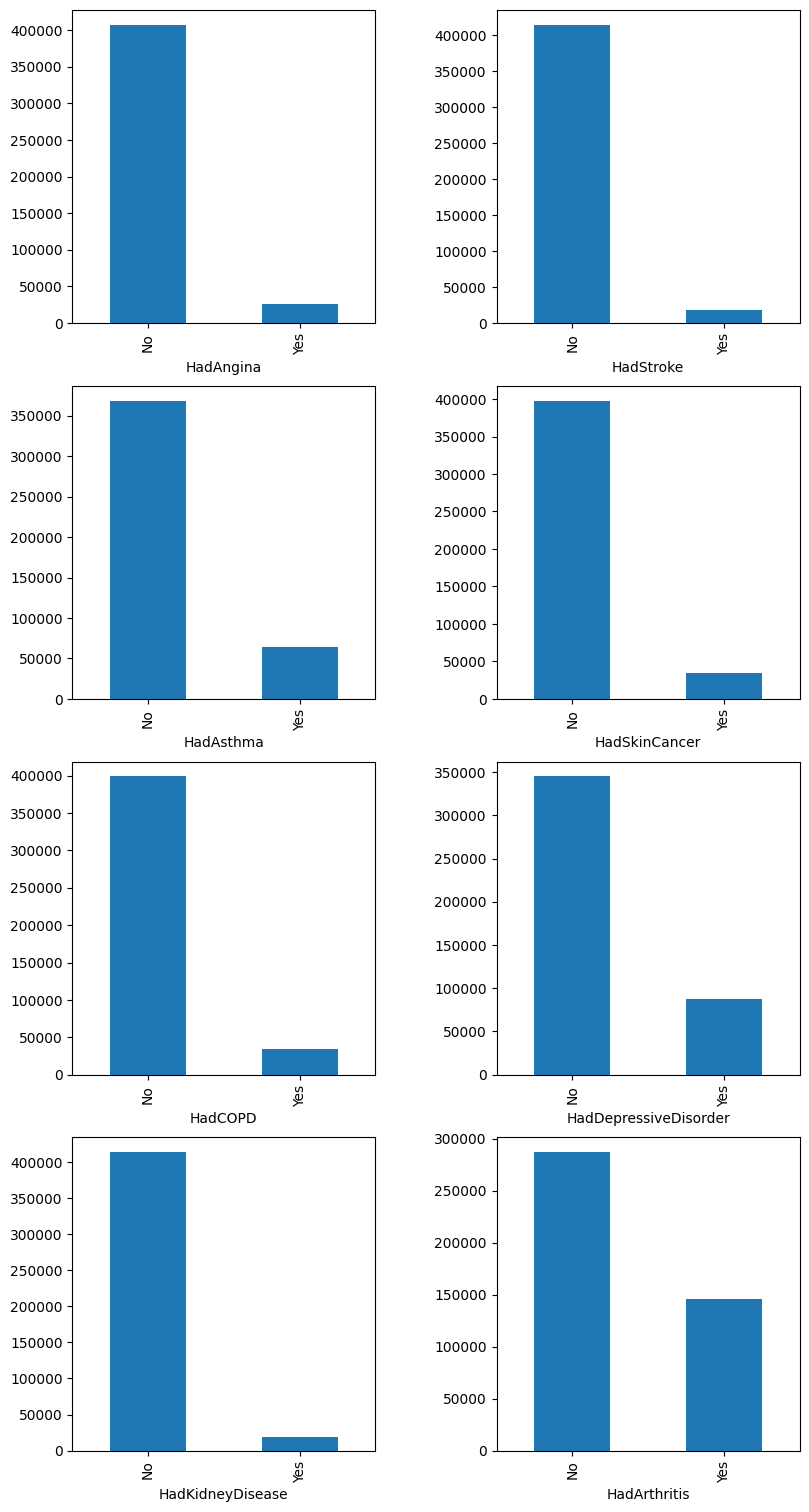

In [28]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8, 15))
flat_ax = ax.ravel()
fig.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.2)

for ax, c in zip(flat_ax, ['HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis']):
    df[c].value_counts().plot(kind='bar', ax=ax)

The following plot visualizes which races are included by age.  
Some racial groups have fewer elderly people, but they are not so unbalanced as to be entirely absent.

<Axes: xlabel='AgeCategory'>

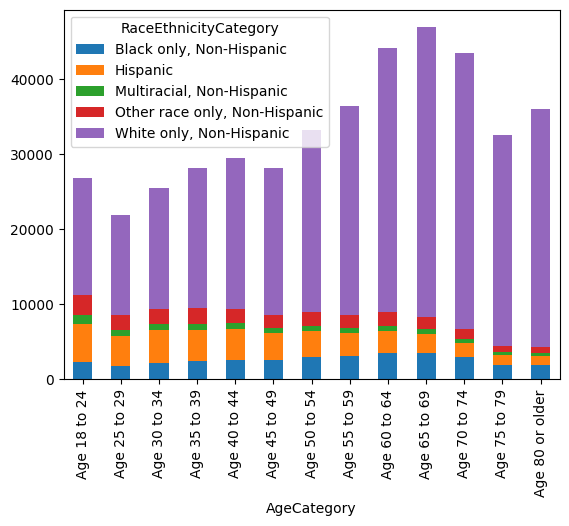

In [29]:
grouped = df.groupby(['AgeCategory', 'RaceEthnicityCategory']).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True)

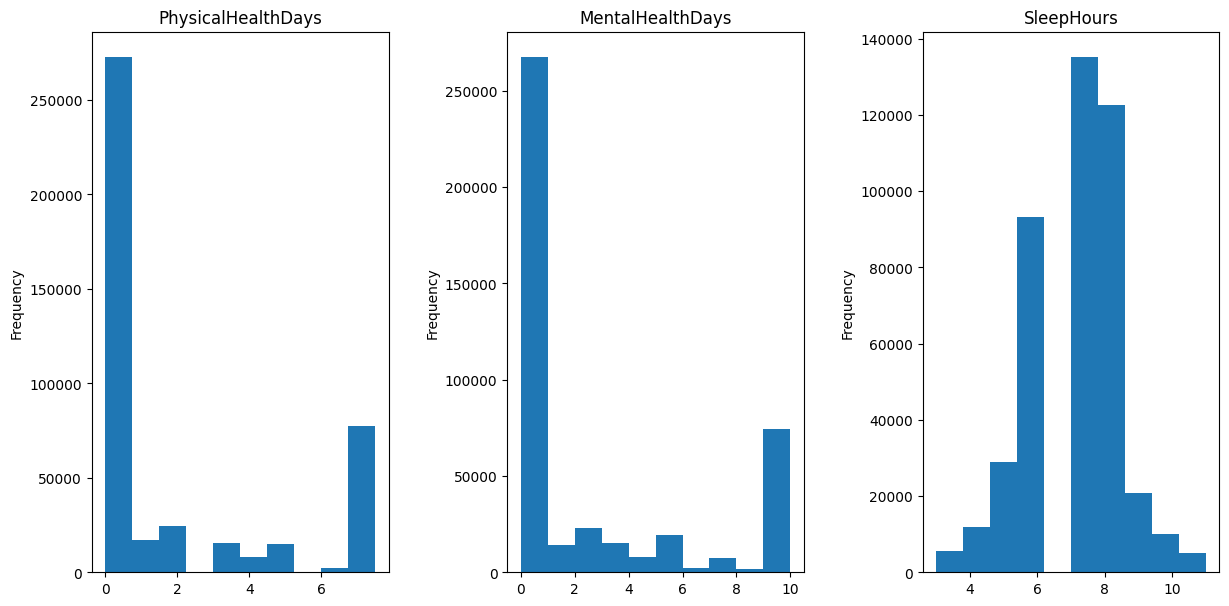

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
flat_ax = ax.ravel()
fig.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.2)


# simple hist plot
for ax, c in zip(flat_ax, ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours']):
    ax.set_title(c)
    df[c].plot(kind='hist', ax=ax)

The following plot combines categorical and target variables to visualize the prevalence of heart disease for each label that the categorical variable has.

In the following two features, we can see that there is a relationship that is easy for humans to understand:
* The healthier the GeneralHealth (Excellent > Very good > Good > Fair > Poor), the lower the percentage of HadHeartAttack
* The older the AgeCategory, the higher the percentage of HadHeartAttacks

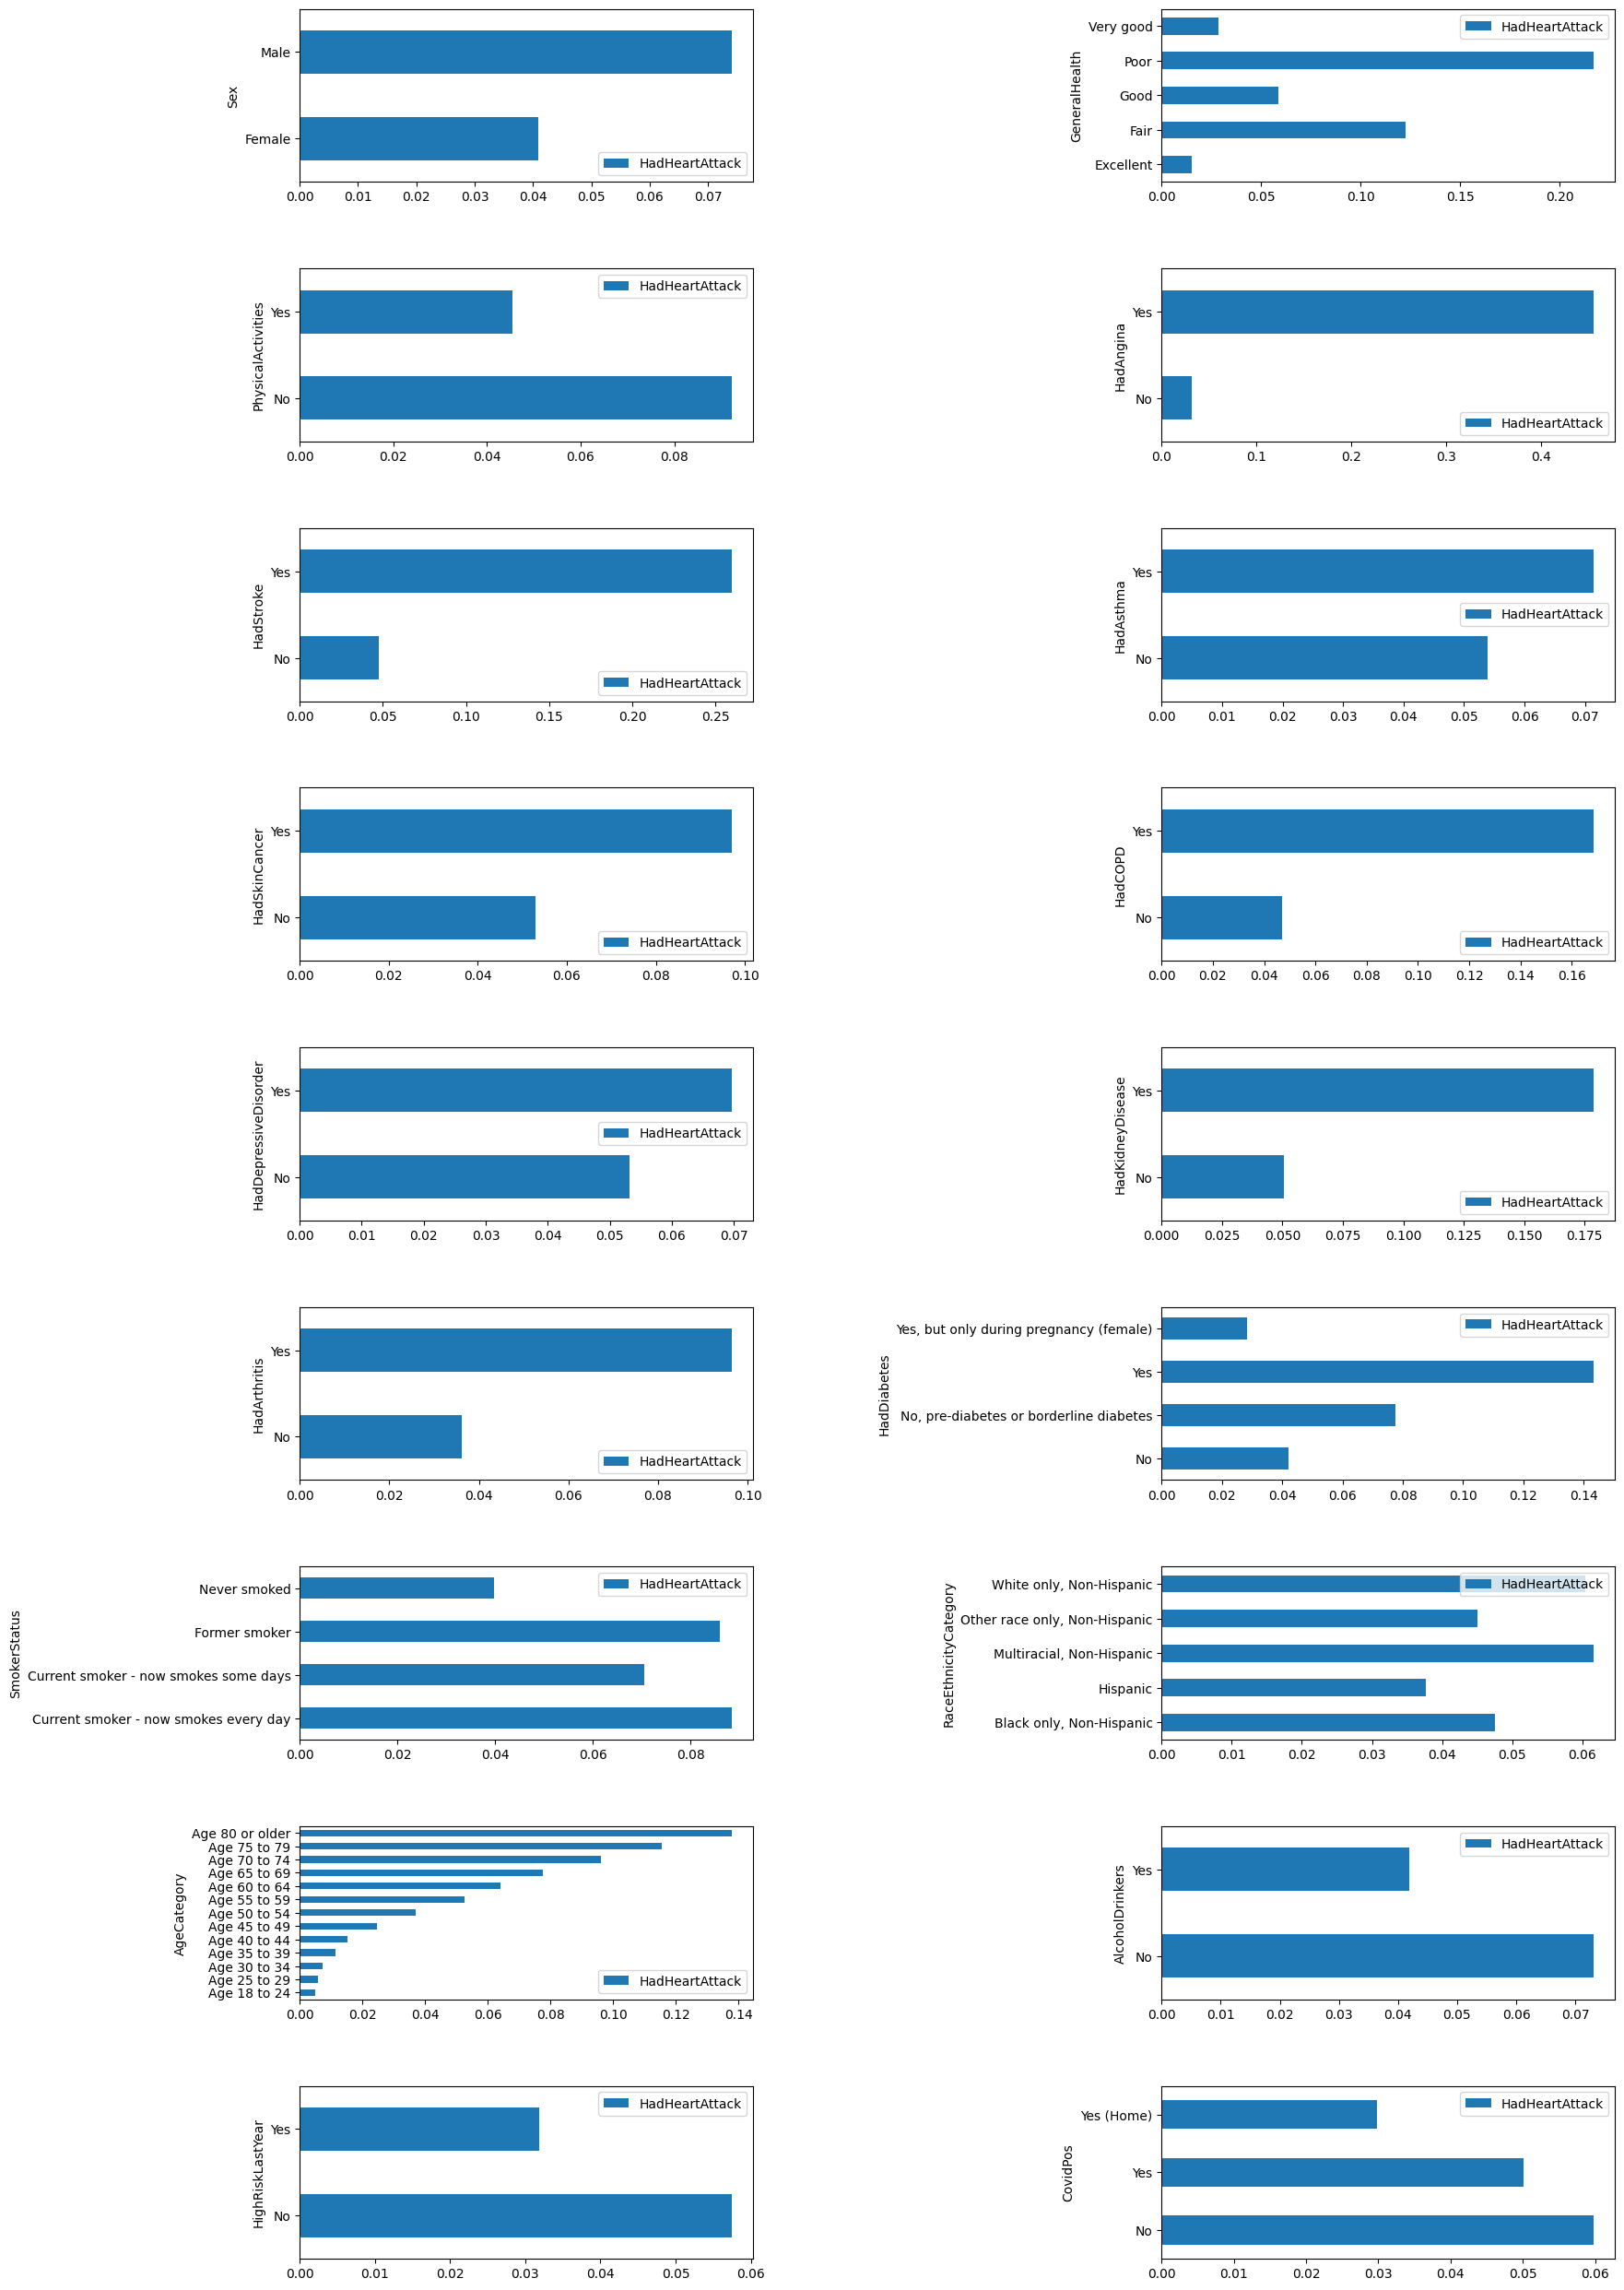

In [31]:
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(15, 25))
flat_ax = ax.ravel()
fig.tight_layout()
plt.subplots_adjust(wspace=0.9, hspace=0.5)

df1 = df.copy()
df1['HadHeartAttack'].replace({ 'Yes': 1, 'No': 0 }, inplace=True)
df1['CovidPos'].replace({ 'Yes': 'Yes', 'No': 'No', 'Tested positive using home test without a health professional': 'Yes (Home)' }, inplace=True)

for ax, c in zip(flat_ax, df1.drop(columns=['HadHeartAttack']).select_dtypes('object').columns):
    df1[['HadHeartAttack', c]].groupby(c).mean().plot(kind='barh', ax=ax)

## Numeric

These plots are combined the mean of numeric columns with the target variable.

* I thought sleep time is important for health, but contrary to what I expected, it doesn't seem to have much of an effect on heart disease.


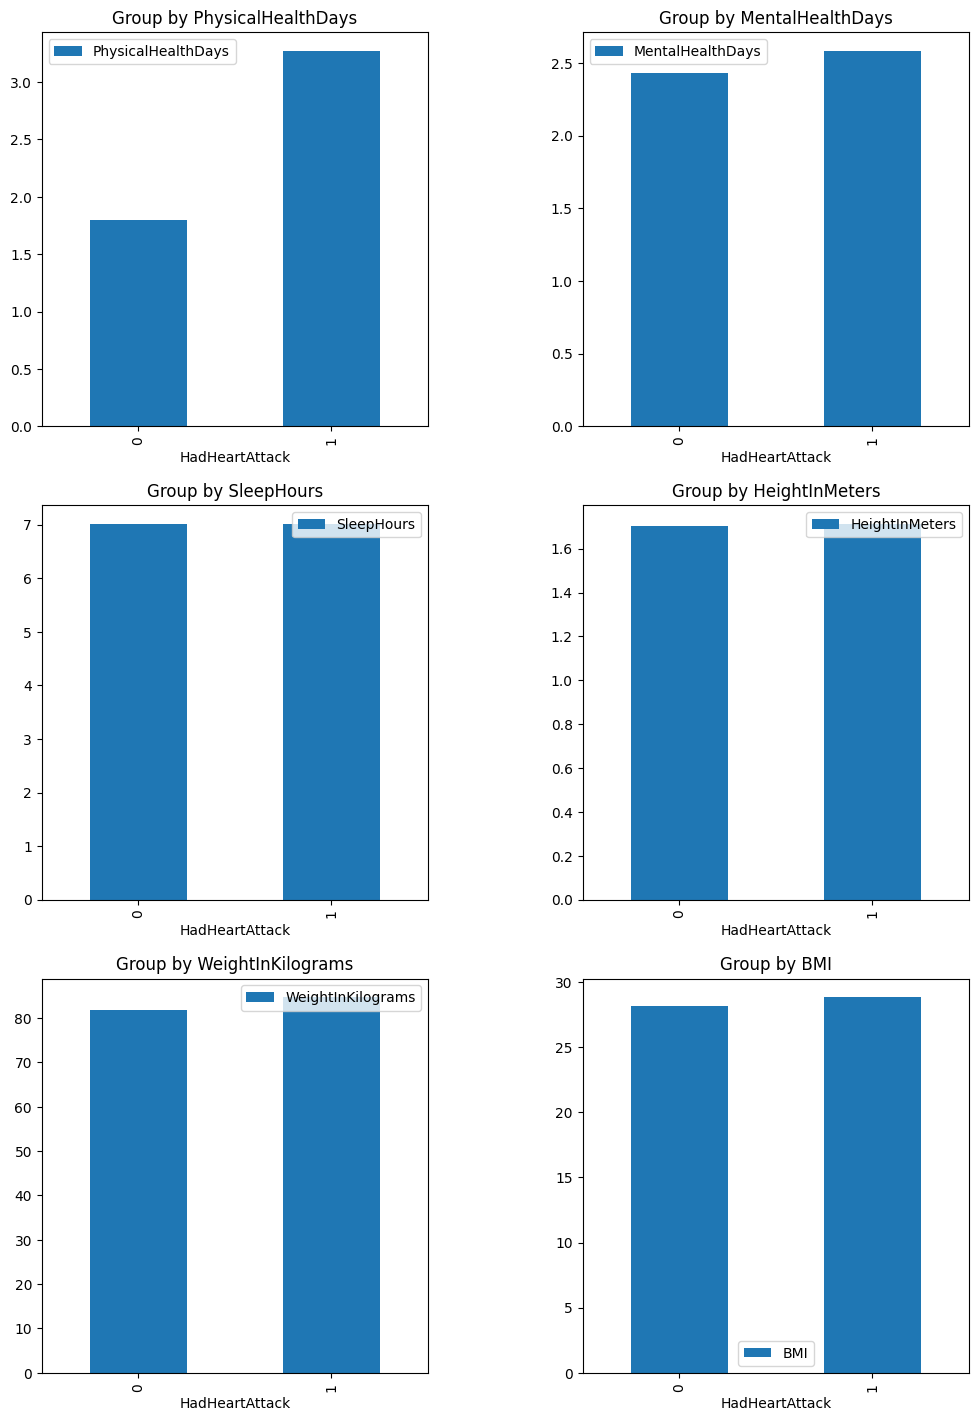

In [32]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 14))
flat_ax = ax.ravel()
fig.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.2)

for ax, c in zip(flat_ax, df1.drop(columns=['HadHeartAttack']).select_dtypes(include=['float64', 'int64']).columns):
    ax.set_title('Group by {}'.format(c))
    df1[['HadHeartAttack', c]].groupby('HadHeartAttack').mean().plot(kind='bar', ax=ax)

## Heatmap

* What we find in the heatmap:
  * The correlation between BMI and weight is too large. It would be better to drop.
  * Depressive disorder and mental health have relationship.
  * Arthritis correlates with age.
  * Angina correlates with heart disease.
  * Physical health is a major contributor to general health.

In [33]:
# encode categorical columns for visualization

for c in ['HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'AlcoholDrinkers', 'HighRiskLastYear']:
    df1[c].replace({ 'Yes': 1, 'No': 0 }, inplace=True)

df1['CovidPos'].replace({ 'Yes': 1, 'Yes (Home)': 1, 'No': 0 }, inplace=True)
df1['GeneralHealth'].replace({ 'Excellent': 1, 'Very good': 2, 'Good': 3, 'Fair': 4, 'Poor': 5 }, inplace=True)
df1['HadDiabetes'].replace({ 'No': 0, 'No, pre-diabetes or borderline diabetes': 2, 'Yes, but only during pregnancy (female)': 1, 'Yes': 3 }, inplace=True)
df1['AgeCategory'].replace({ 'Age 18 to 24': 1, 'Age 25 to 29': 2, 'Age 30 to 34': 3, 'Age 35 to 39': 4, 'Age 40 to 44': 5, 'Age 45 to 49': 6, 'Age 50 to 54': 7, 'Age 55 to 59': 8, 'Age 60 to 64': 9, 'Age 65 to 69': 10, 'Age 70 to 74': 11, 'Age 75 to 79': 12, 'Age 80 or older': 13 }, inplace=True)

<Axes: >

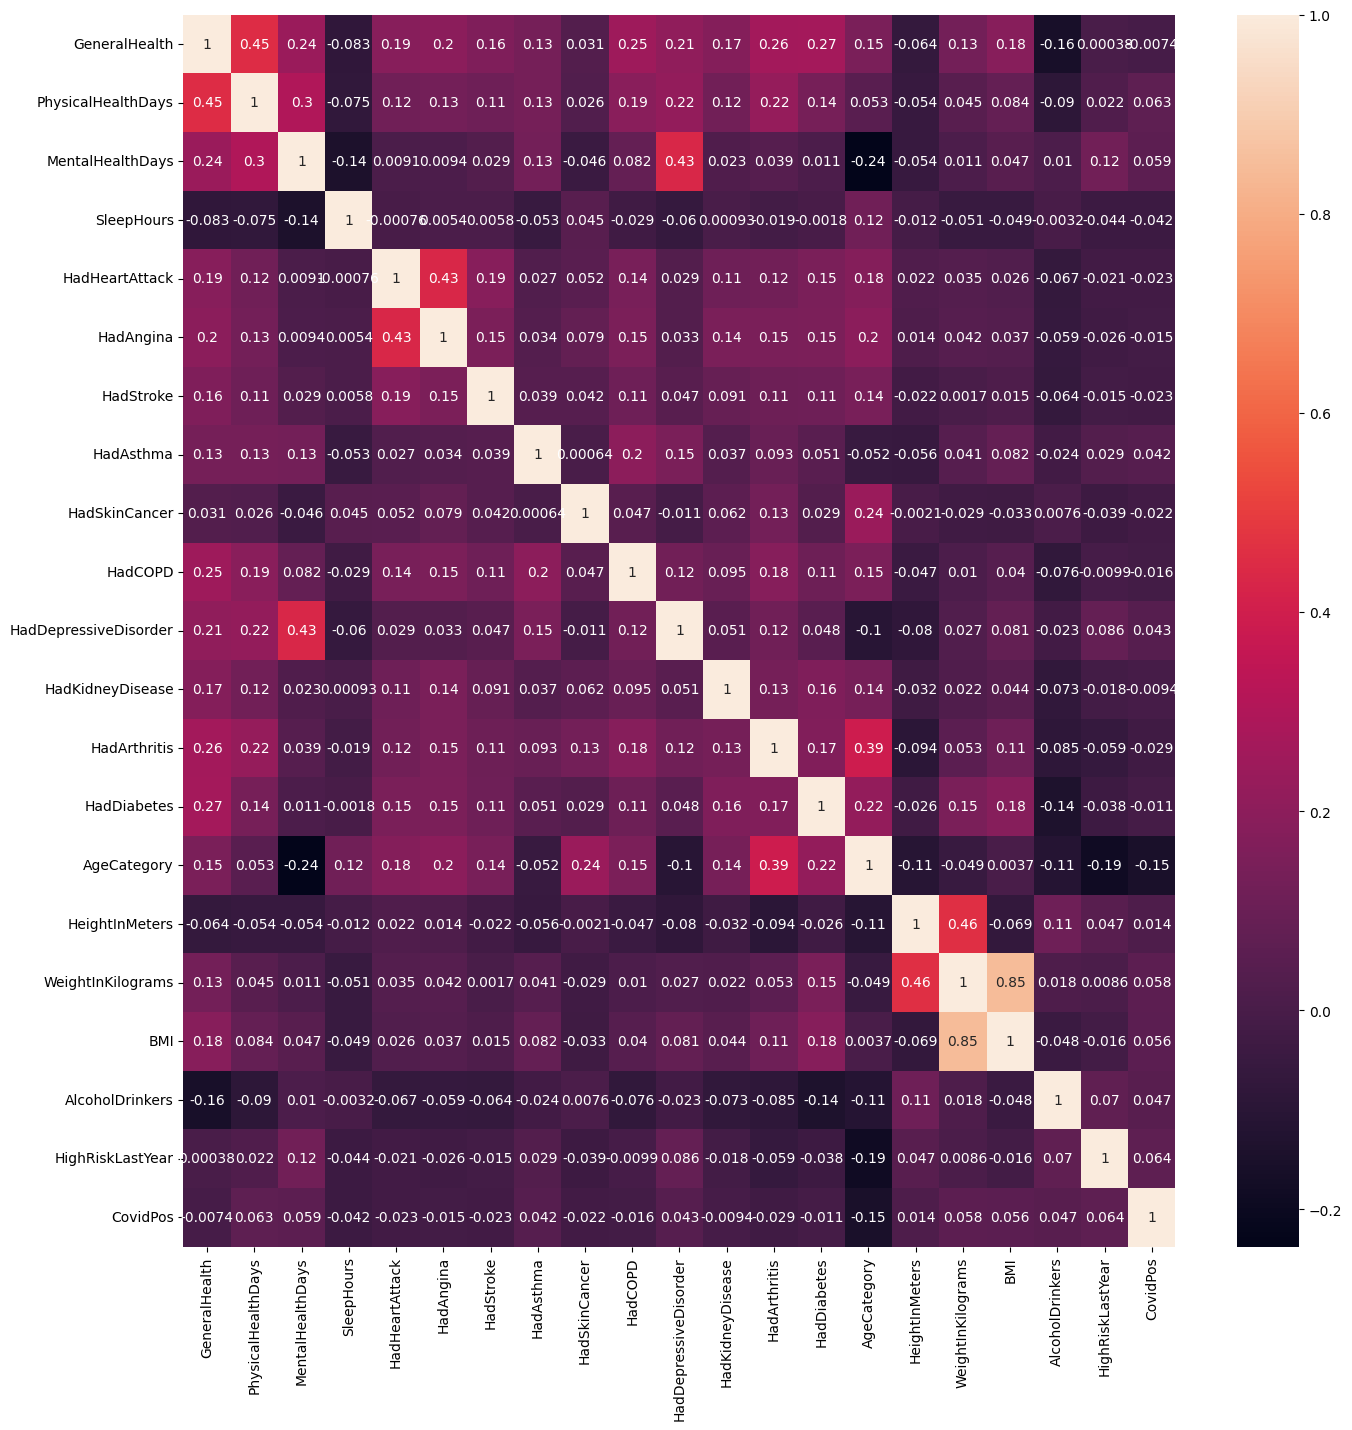

In [34]:
plt.figure(figsize=(16, 16))
sns.heatmap(df1.select_dtypes(include=['float64', 'int64']).corr(), annot=True)

# Feature Engineering / Models

There are correlation between BMI and WeightInKilograms so I drop `WeightInKilograms` additionally.

In [35]:
df.drop(columns=['WeightInKilograms'], inplace=True)

Here, categorical variables are encoded in a form that can be input into the machine learning model.

* Columns like Sex, and columns which have Yes/No values use One Hot Representation
* Use OrdinalEncoder for labels such as General Health and age, for which ordering seems valid.
* Target Column is converted to 0/1 within the same column.

In [36]:
# Encode Categorical Columns
tf = ColumnTransformer(
    transformers=[
        ('cat_type1', OneHotEncoder(drop='first'), ['Sex', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'AlcoholDrinkers', 'HighRiskLastYear', 'CovidPos', 'HadDiabetes', 'RaceEthnicityCategory', 'SmokerStatus', 'PhysicalActivities']),
        ('cat_type2', OrdinalEncoder(categories=[
            ['Excellent', 'Very good', 'Good', 'Fair', 'Poor'],
            ['Age 18 to 24', 'Age 25 to 29', 'Age 30 to 34', 'Age 35 to 39', 'Age 40 to 44', 'Age 45 to 49', 'Age 50 to 54', 'Age 55 to 59', 'Age 60 to 64', 'Age 65 to 69', 'Age 70 to 74', 'Age 75 to 79', 'Age 80 or older'],
        ]), ['GeneralHealth', 'AgeCategory']), # fixme give encoder the categories
    ],
    remainder='passthrough'
)

df1 = tf.fit_transform(df)

column_names = []
for c in tf.get_feature_names_out():
    column_names.append(c.split('__')[1])
df = pd.DataFrame(df1, columns=column_names)


le = LabelEncoder()
df['HadHeartAttack'] = le.fit_transform(df['HadHeartAttack'])

for c in df.select_dtypes('object'):
    df[c].astype('int64')

Next, normalize the numeric columns with sklearn's StandardScaler.
This is to use the linear model when we build the model later.

In [37]:
# Scaling
scaler = StandardScaler()
columns = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'BMI']
df[columns] = scaler.fit_transform(df[columns])

df.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HadHeartAttack,HeightInMeters,BMI
count,4.327230e+05,4.327230e+05,4.327230e+05,432723.000000,4.327230e+05,4.327230e+05
mean,4.545130e-17,1.366166e-17,-1.820679e-16,0.056484,2.525306e-15,4.291601e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,0.230855,1.000001e+00,1.000001e+00
min,-6.488413e-01,-6.419228e-01,-2.988694e+00,0.000000,-2.894615e+00,-3.326346e+00
25%,-6.488413e-01,-6.419228e-01,-7.535847e-01,0.000000,-6.956775e-01,-7.094971e-01
50%,-6.488413e-01,-6.419228e-01,-8.548437e-03,0.000000,-2.643552e-02,-1.385576e-01
75%,3.879357e-01,4.101895e-01,7.364878e-01,0.000000,7.384124e-01,5.730238e-01
max,1.943101e+00,1.988358e+00,2.971597e+00,1.000000,3.032956e+00,3.498042e+00


### Handle imbalance with SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) is an over-sampling technique developed to address the problem of unbalanced data sets. It addresses the large imbalance in the target column which I mentioned above. Here I use the python library.

<Axes: xlabel='HadHeartAttack'>

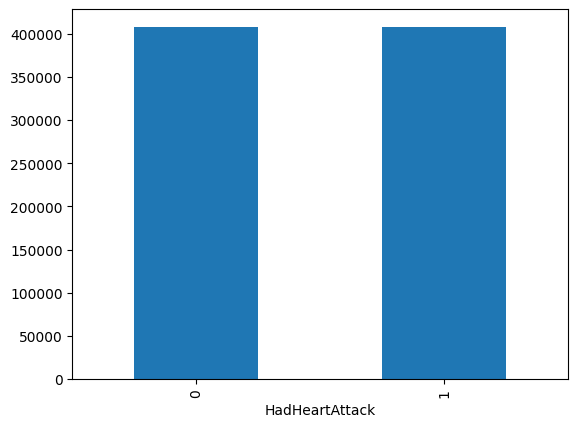

In [38]:
# SMOTE

X = df.drop('HadHeartAttack', axis=1)
y = df['HadHeartAttack']

smote = SMOTE(sampling_strategy='minority')
Xs, ys = smote.fit_resample(X, y)

ys.value_counts().plot(kind='bar')

Split data to train and test.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=44)

In [40]:
def show_roc_auc_curve(fpr, tpr, score):
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {score:.2f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [41]:
scores = []

## Baseline model: LogisticRegression

Let's get started with Logistic Regression as a baseline model.

ROC AUC Score: 0.8818


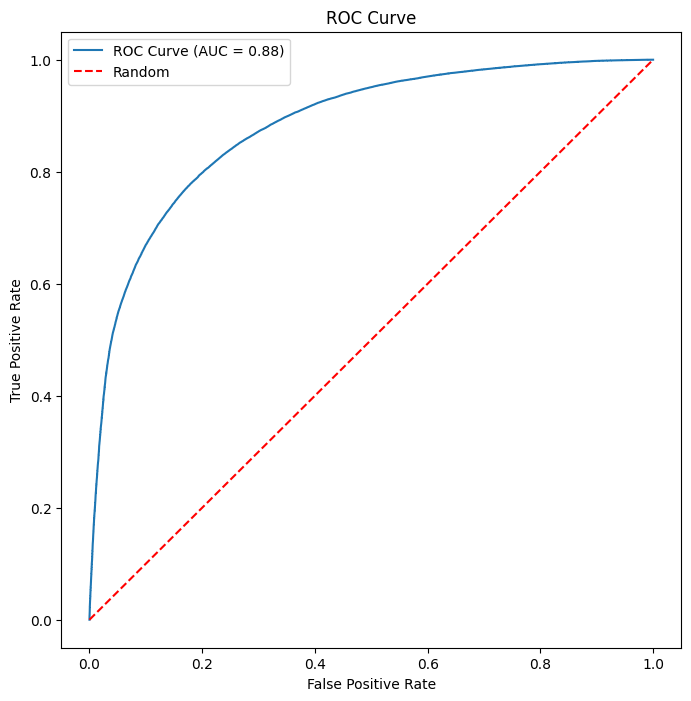

In [42]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=44).fit(X_train, y_train)

y_pred = lr.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])
score = auc(fpr, tpr)

print('ROC AUC Score: {:.4f}'.format(score))
show_roc_auc_curve(fpr, tpr, score)

In [43]:
y_pred = lr.predict(X_test)
f1 = f1_score(y_test, y_pred)
scores.append(['LogisticRegiression', score, f1])

I got AUC = 0.88. However, the accuracy is not that high.  
To improve performance of this model, I'm going to attempt to tune a parameter, `C`.

In [44]:
for c in [0.01, 0.1, 1, 10, 100]:
    lr1 = LogisticRegression(C=c, random_state=44).fit(X_train, y_train)

    y_pred = lr1.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])
    score1 = auc(fpr, tpr)

    print('C={}, ROC AUC Score: {:.4f}'.format(c, score1))

C=0.01, ROC AUC Score: 0.8818
C=0.1, ROC AUC Score: 0.8818
C=1, ROC AUC Score: 0.8818
C=10, ROC AUC Score: 0.8818
C=100, ROC AUC Score: 0.8819


Varying parameter C does not significantly improve performance. Because of the large number of categorical variables, no further improvement may be expected.

Next, we would like to try a non-linear model.

## RandomForest

ROC AUC Score: 0.9962


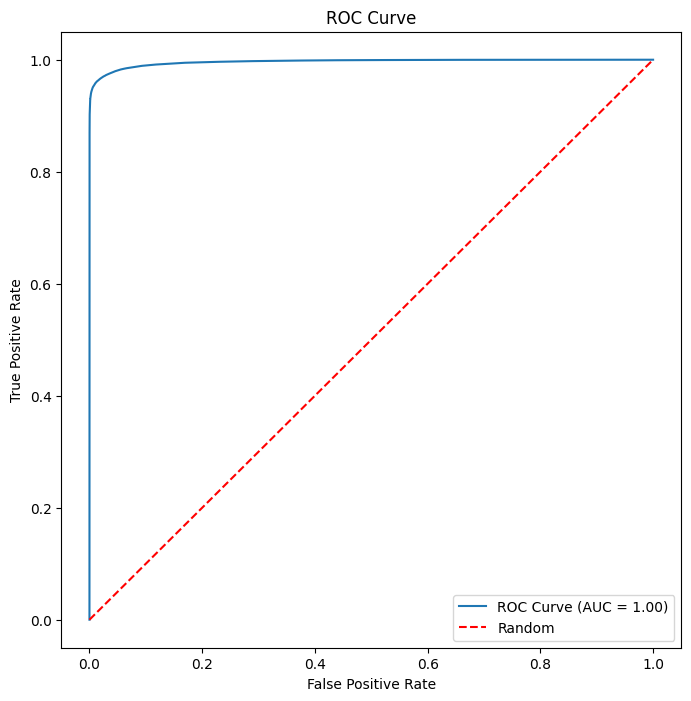

In [45]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=44).fit(X_train, y_train)

y_pred = rf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])
score = auc(fpr, tpr)

print('ROC AUC Score: {:.4f}'.format(score))
show_roc_auc_curve(fpr, tpr, score)

In [46]:
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred)
scores.append(['RandomForest', score, f1])

## Gradient Boosting

ROC AUC Score: 0.9818


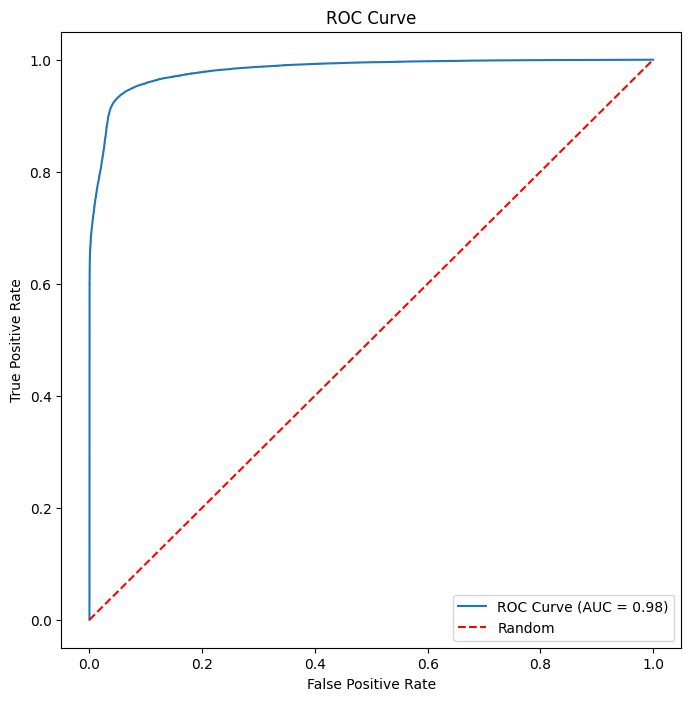

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=44).fit(X_train, y_train)

y_pred = gb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])
score = auc(fpr, tpr)

print('ROC AUC Score: {:.4f}'.format(score))
show_roc_auc_curve(fpr, tpr, score)

In [48]:
y_pred = gb.predict(X_test)
f1 = f1_score(y_test, y_pred)
scores.append(['GradientBoosting', score, f1])

## Decision Tree

ROC AUC Score: 0.9495


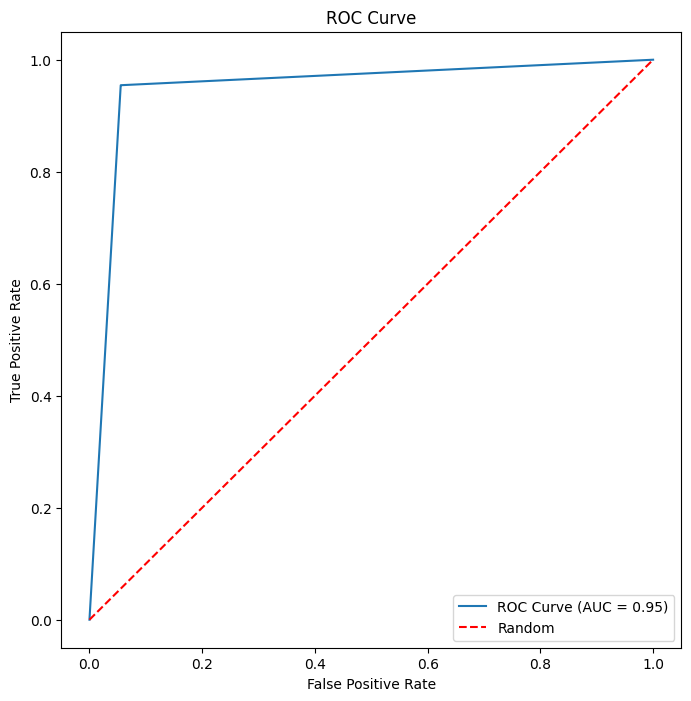

In [49]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=44).fit(X_train, y_train)

y_pred = dt.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])
score = auc(fpr, tpr)

print('ROC AUC Score: {:.4f}'.format(score))
show_roc_auc_curve(fpr, tpr, score)

In [50]:
y_pred = dt.predict(X_test)
f1 = f1_score(y_test, y_pred)
scores.append(['DecisionTree', score, f1])

## DecisionTreeClassifier with Parameter Tuning

DecisionTree has a relatively low AUC=0.95 among the nonlinear models tested in this study. Let's try tuning the parameters.

Best parameters found:  {'ccp_alpha': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 100}
ROC AUC Score: 0.9826


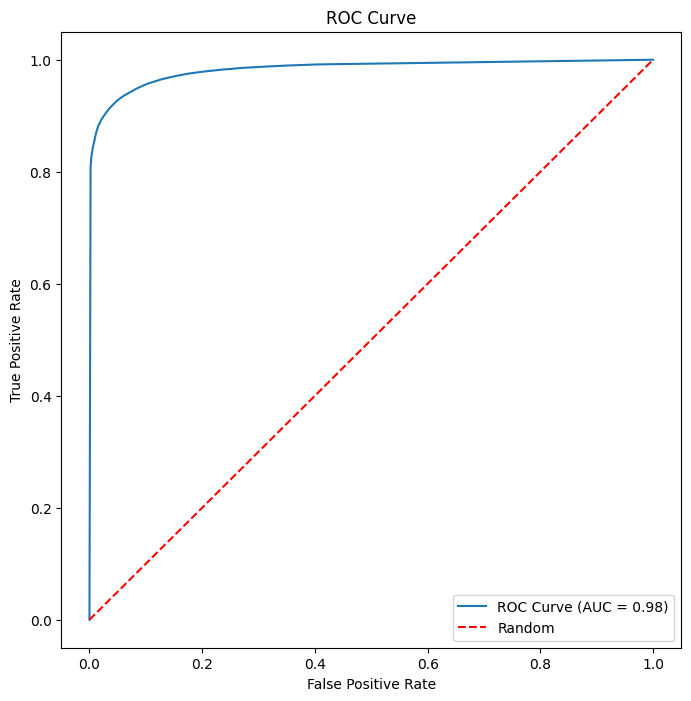

In [51]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'min_samples_split': [2, 5, 10, 50, 100],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'ccp_alpha': [0.0, 0.01, 0.1]
}

dt2 = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=dt2, param_grid=param_grid, cv=3, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])
score = auc(fpr, tpr)

print('ROC AUC Score: {:.4f}'.format(score))
show_roc_auc_curve(fpr, tpr, score)

In [52]:
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
scores.append(['DecisionTree (Fine-Tuned)', score, f1])

It's improved. The final score is over 0.98.

## Models comparison and Analysis

This section lists the AUC and F1 scores for the models so far, and we visualize the feature importance of each model.

The table below shows the scores for the models. The top scoring model in this data set was random forest.  
Random Forest takes the average of a large number of trees trained on bootstrap sampled samples, resulting in high generalization performance.

In [53]:
scores_df = pd.DataFrame(scores, columns=['model', 'roc_auc', 'f1'])
scores_df.sort_values(by='roc_auc')

,model,roc_auc,f1
0,LogisticRegiression,0.881841,0.789746
3,DecisionTree,0.949502,0.949747
2,GradientBoosting,0.981789,0.937283
4,DecisionTree (Fine-Tuned),0.982577,0.937956
1,RandomForest,0.996212,0.973390


### Logistic Regression Feature Importance

To be precise, these are the coefficients of a linear model.

* The most significant feature is `HadAngina_Yes`.
* It was unexpected that `CovidPos_Tested positive using home test without a health professional` has a coefficient with a large absolute value.

<Axes: ylabel='Feature'>

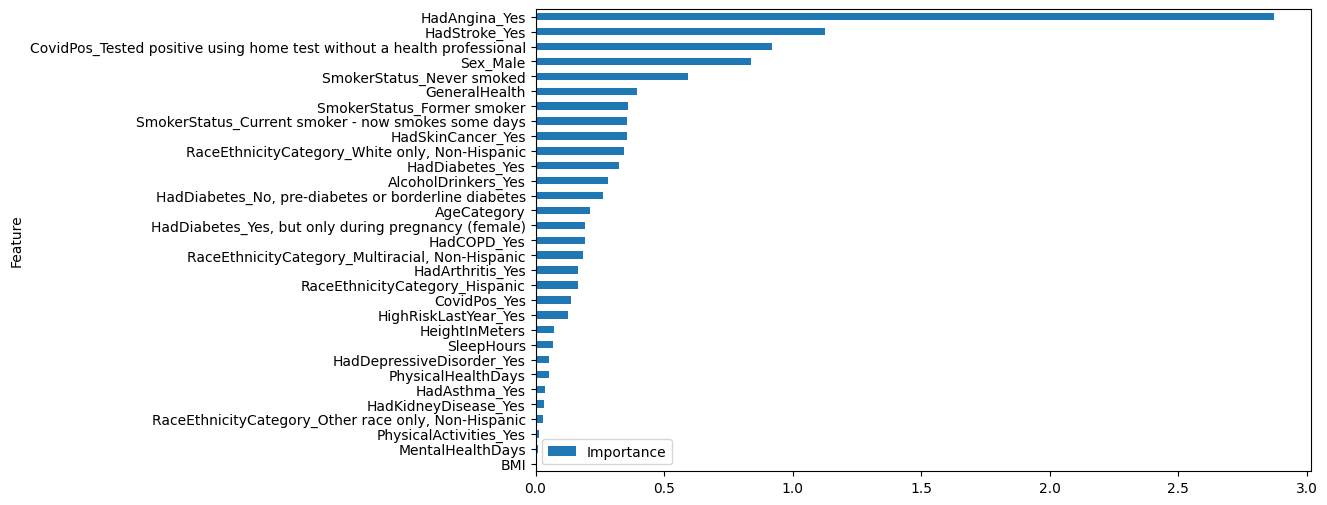

In [54]:
coefficients = lr.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

### RF Feature Importance

* The most significant feature is `HadAngina_Yes` as well as RandomForest.
* `AgeCategory` and `GeneralHealth` followed as the next contributing features. This is intuitive for humans.

<Axes: ylabel='Feature'>

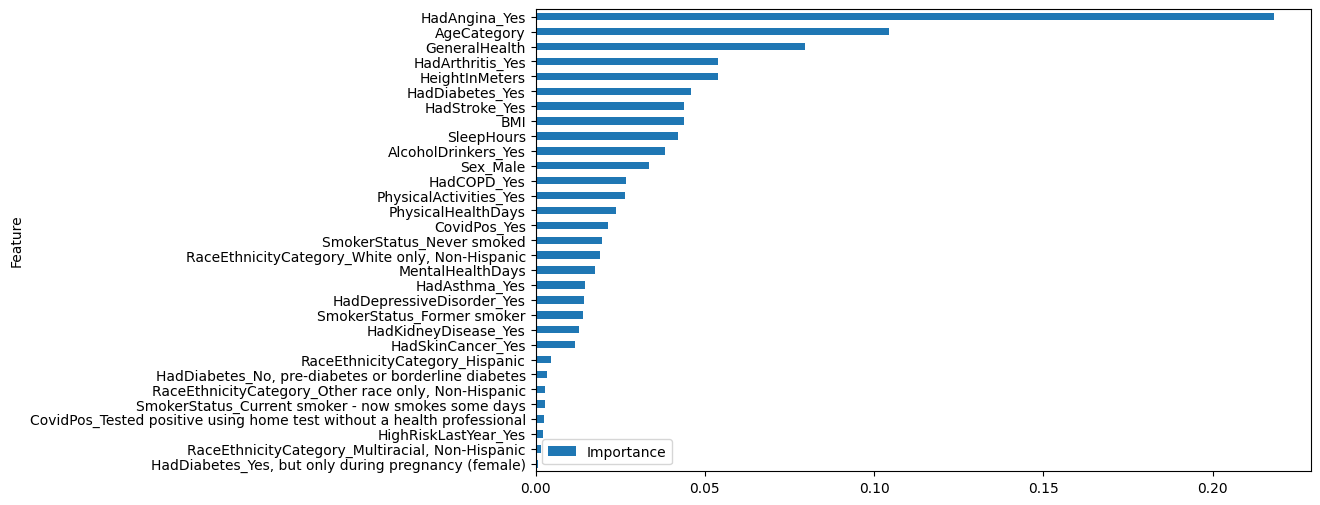

In [55]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

### GradientBoosting Feature Importance

* HadAngina_Yes also contributes the most to this model.
* Overall, the number of columns with valid contributions appears to be small. In other words, it appears that the training is being done using only a portion of the input that is given.
* It is also interesting to note that columns that were effective in the RandomForest, such as BMI, contributed almost nothing.

<Axes: ylabel='Feature'>

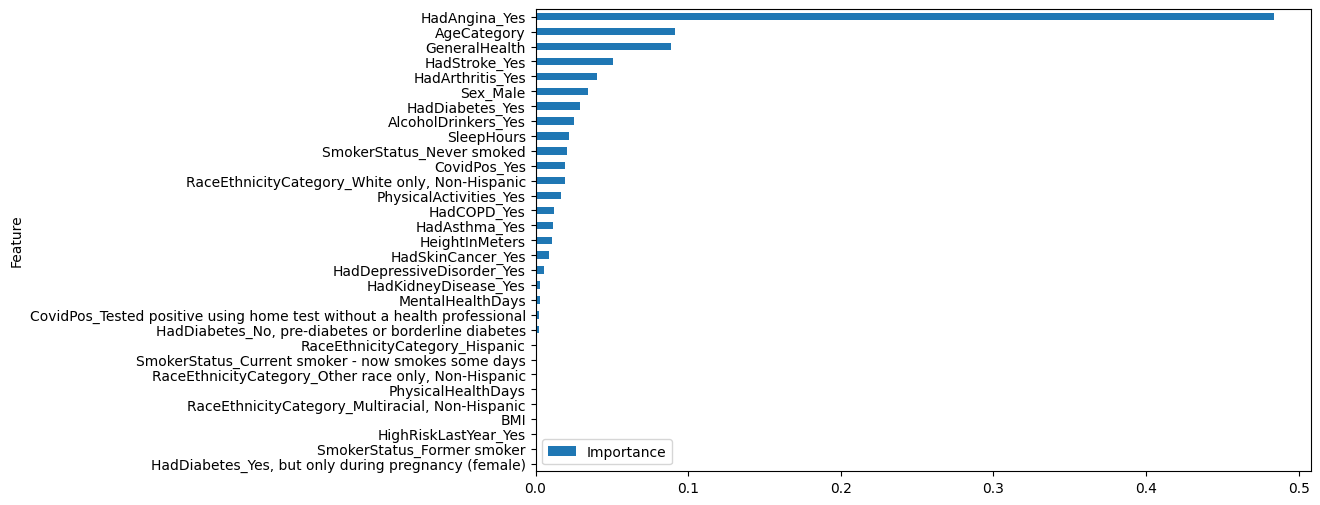

In [56]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': gb.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

### DecisionTree Feature Importance

* The feature importance appears to be the same as in previous nonlinear models.
* The number of columns contributed is between RandomForest and GradientBoosting.

<Axes: ylabel='Feature'>

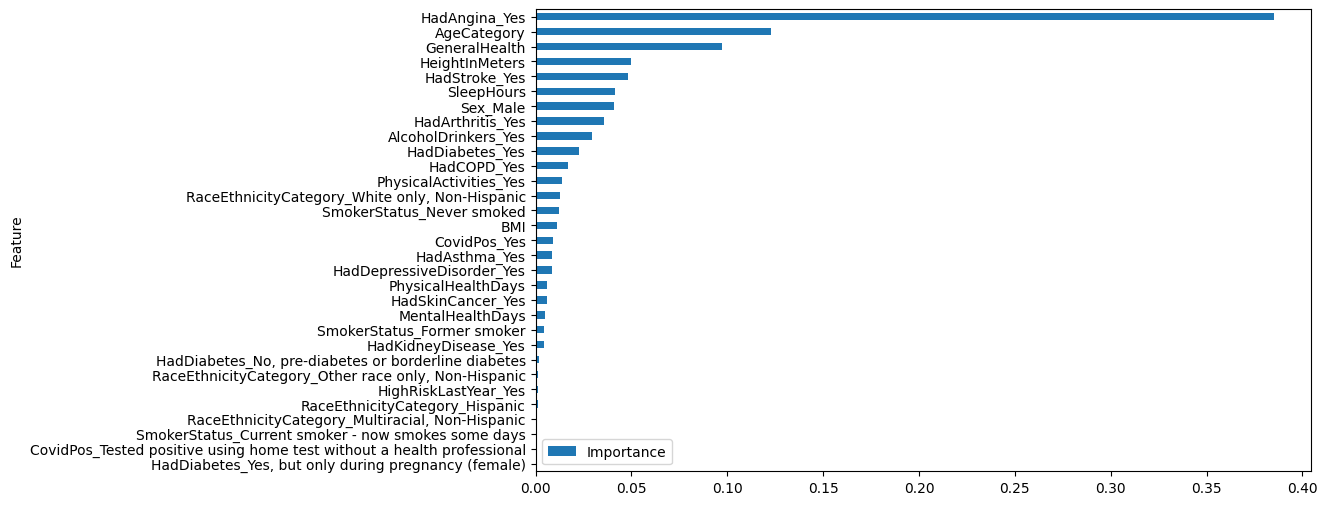

In [57]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': best_model.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

## Additional iteration to improve GradientBoosting score

Based on our analysis so far, it seems that GradientBoosting has some characteristics that differ from the others and that there is room for improvement. Since I thought that training with fewer columns than the other models would require a deeper tree structure, so I'm going to  increas the maximum depth setting along with a few parameters.

ROC AUC Score: 0.9910


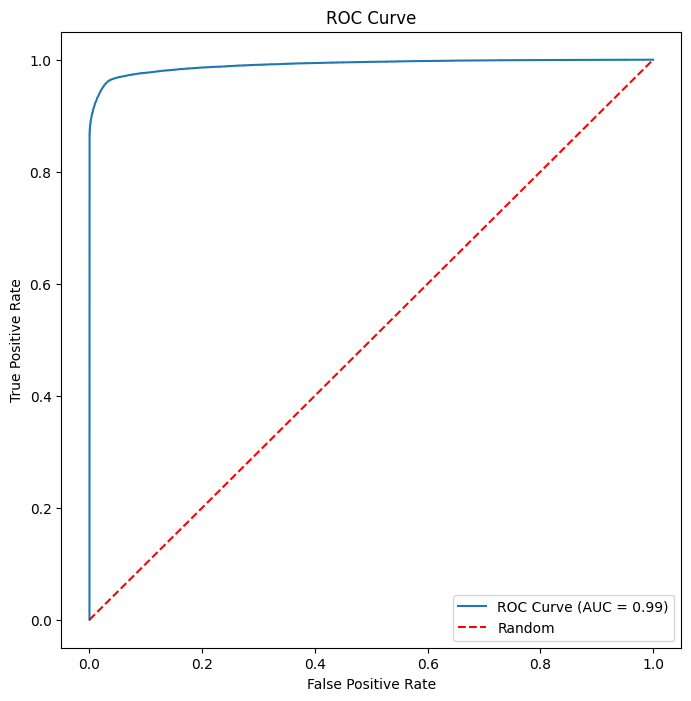

In [58]:
gb2 = GradientBoostingClassifier(
    max_depth=6,
    subsample=0.8,
    min_samples_leaf=4,
    min_samples_split=100,
    random_state=44
).fit(X_train, y_train)

y_pred = gb2.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])
score = auc(fpr, tpr)

print('ROC AUC Score: {:.4f}'.format(score))
show_roc_auc_curve(fpr, tpr, score)

Now we got AUC = 0.9914, previously 0.9825. It gets better.

Once again, feature importance is plotted below. However, there is no significant change.　This is probably due to the depth of the tree, rather than any change in the configuration of the features used.

<Axes: ylabel='Feature'>

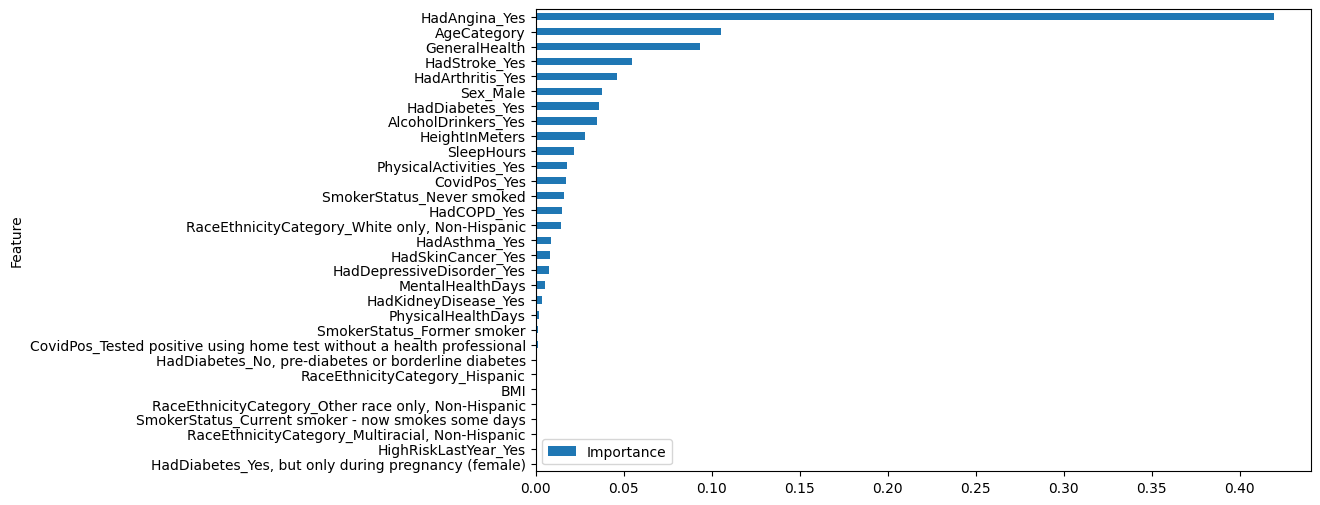

In [59]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': gb2.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

# Conclusion

This project implemented the task of classifying binary labels of presence or absence of heart disease using a dataset based on statistical data from a survey of US adults' lifestyles and other data.

I cleaned the data while analyzing its characteristics, used techniques such as SMOTE to address imbalances, and used LogisticRegression, RandomForest, DecisionTree, and GradientBoosting as models. The best score was achieved with RandomForest with a roc auc score = 0.99.

I analyzed the performance and feature importance of each model and discussed what characteristics they have. Furthermore, I examined the cause of GradientBoosting, which scored lower than RandomForest among the nonlinear models, and tuned the parameters based on the hypothesis that the depth of the tree was insufficient, and were able to improve performance.


**Why something didn’t work?**

LogisticRegression did not fit well and scored poorly, but I believe this is because it is a linear model. It did not work well in the current data set, which is mainly categorical variables.

**Suggested ways to improve**

In order to achieve better results in more practical situations, it may be possible to further improve the results by choosing an implementation that allows more diverse and fine-tuning (more parameters that can be changed). In this case, I used the scikit-learn model, but LightGBM and XGBoost, for example, are popular options.